In [3]:
from datetime import datetime
import tweepy
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from config import consumer_key, consumer_secret, access_token, access_token_secret
from matplotlib import style
style.use('ggplot')

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [23]:
# news outlets for looping
newsOutlets = ["@BBC", '@CBS', '@CNN', '@FoxNews', '@NYTimes']

# set number of tweets for looping
nTweets = 100

# create empty lists for appending
sentiment = []
compoundList = []
neutralList = []
positiveList = []
negativeList = []
name = []
counterList = []
overallCompound =[]
overallOutlet = []
date = []
text = []

# loop through the news outlets
for outlet in newsOutlets:
    overallList = []
    overallName = ''
    counter = 0
    
    # loop through the tweets using tweepy
    for status in tweepy.Cursor(api.user_timeline, id=outlet, tweet_mode="extended").items(nTweets):
        
        # create json file for each tweet
        tweet = status._json
        
        # use vader anlayzer and store as results
        result = analyzer.polarity_scores(tweet['full_text'])
        
        #get name, counter, compound, and pos, neu, neg scores
        name.append(tweet['user']['name'])
        compoundList.append(result['compound'])
        positiveList.append(result['pos'])
        negativeList.append(result['neg'])
        neutralList.append(result['neu'])
        date.append(tweet['created_at'])
        text.append(tweet['full_text'])
        
        #reset counter
        counter += 1
        counterList.append(counter)   
        
        #get overall name and compound score to mean
        overallList.append(result['compound'])
        overallName = tweet['user']['name']
    overallCompound.append(np.mean(overallList))
    overallOutlet.append(overallName)
    
sentiment.append({
    "name": name,
    "compound_score" : compoundList,
    "date": date})


In [24]:
# create overall df to set up for mean scores (bar chart)
overallDf = pd.DataFrame({
    "News Outlet": overallOutlet,
    "Compound Score" : overallCompound})

In [26]:
# create sentiment df for scatter plot
sentimentDf = pd.DataFrame({
    "name": name,
    "Compound" : compoundList,
    "Positive" : positiveList,
    "Negative" : negativeList,
    "Neutral" : neutralList,
    "text": text,
    "date": date})


In [27]:
# save as csv file
sentimentDf.to_csv("twitterSentiment.csv")

In [28]:
# change date to datetime
sentimentDf["date"] = pd.to_datetime(sentimentDf["date"])
# sentiment_df.head(100)

In [29]:
# sort values by date
sentimentDf.sort_values("date", inplace=True, ascending=True)
sentimentDf.head()

,Compound,Negative,Neutral,Positive,date,name,text
199,0.4885,0.151,0.615,0.234,2018-03-01 18:10:50,CBS,RT @KeithUrban: ACMs...... HOLY SMOKES!!!!! MA...
198,0.8591,0.000,0.462,0.538,2018-03-01 18:11:50,CBS,RT @KelseaBallerini: Ohhhhh goodness. Incredib...
197,0.4547,0.092,0.749,0.159,2018-03-01 18:12:57,CBS,RT @MarenMorris: Hot damn! Woke up from my pos...
196,-0.6981,0.210,0.790,0.000,2018-03-01 18:59:01,CBS,RT @ZoeListerJones: Tonight’s an all new Life ...
195,0.4215,0.033,0.892,0.075,2018-03-02 18:45:00,CBS,"In honor of Women's History Month, CBS and the..."


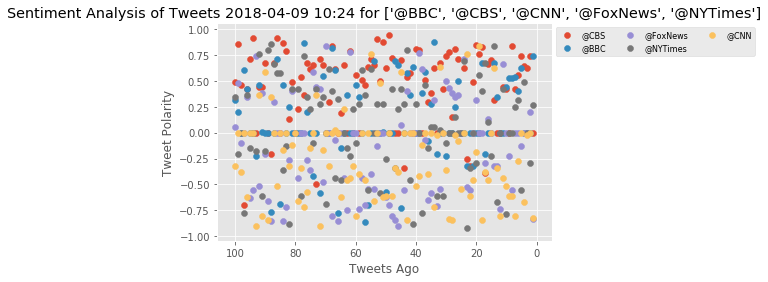

In [30]:
# create scatter plot for each news outlet, use color to identify each

plt.scatter(np.arange(-len(sentimentDf[sentimentDf['name'] == "CBS"]),0,1), 
            sentimentDf[sentimentDf['name'] == "CBS"]['Compound'], label = "@CBS")

plt.scatter(np.arange(-len(sentimentDf[sentimentDf['name'] == "BBC"]),0,1), 
            sentimentDf[sentimentDf['name'] == "BBC"]['Compound'],  label = "@BBC")

plt.scatter(np.arange(-len(sentimentDf[sentimentDf['name'] == "Fox News"]),0,1), 
            sentimentDf[sentimentDf['name'] == "Fox News"]['Compound'], label = "@FoxNews")

plt.scatter(np.arange(-len(sentimentDf[sentimentDf['name'] == "The New York Times"]),0,1), 
            sentimentDf[sentimentDf['name'] == "The New York Times"]['Compound'],  label = "@NYTimes")

plt.scatter(np.arange(-len(sentimentDf[sentimentDf['name'] == "CNN"]),0,1), 
            sentimentDf[sentimentDf['name'] == "CNN"]['Compound'],  label = "@CNN")

# create now datetime object

now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M")

# Incorporate the other graph properties

plt.title(f"Sentiment Analysis of Tweets {now} for {newsOutlets}")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.xticks([-100, -80, -60, -40, -20, 0], [100, 80, 60, 40, 20, 0])

plt.legend(scatterpoints=1,
           loc='upper left',
           bbox_to_anchor = (1,1),
           ncol=3,
           fontsize=8)
plt.savefig('SentimentOverTime.png')
plt.show()


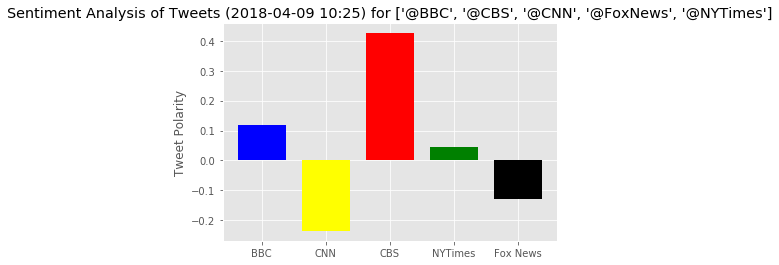

In [31]:
# create variable to store sentiment mean scores for each news outlet
sentimentMean = (overallDf[overallDf['News Outlet'] == 'BBC']['Compound Score'].values[0], 
                  overallDf[overallDf['News Outlet'] == 'CNN']['Compound Score'].values[0], 
                  overallDf[overallDf['News Outlet'] == 'CBS']['Compound Score'].values[0], 
                  overallDf[overallDf['News Outlet'] == 'The New York Times']['Compound Score'].values[0],
                  overallDf[overallDf['News Outlet'] == 'Fox News']['Compound Score'].values[0])

# create bar charts for each news outlet
fig, ax = plt.subplots()
ind = np.arange(len(sentimentMean))  
width = .75
BBC = ax.bar(ind[0], sentimentMean[0], width, color='blue')
CBS = ax.bar(ind[2], sentimentMean[2], width, color='red')
CNN = ax.bar(ind[1], sentimentMean[1], width, color='yellow')
NYTimes = ax.bar(ind[3], sentimentMean[3], width, color='green')
FoxNews = ax.bar(ind[4], sentimentMean[4], width, color='black')

# create now datetime object

now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M")

# Orient widths. Add labels, tick marks, etc. 
ax.set_ylabel('Tweet Polarity')
ax.set_title(f"Sentiment Analysis of Tweets ({now}) for {newsOutlets}")
ax.set_xticks(ind)
ax.set_xticklabels(('BBC', 'CNN', 'CBS', 'NYTimes', 'Fox News'))
ax.set_autoscaley_on(True)
ax.grid(True)
plt.savefig('TweetPolarityByOutlet.png')
plt.show()
